In [1]:
from glob import glob
import gzip
import json
import os
import pickle
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import transforms3d as t3d

%matplotlib inline

このノートではLoss関数を実装するために重要な重ね合わせの方法を確認する。  
何をやるのかを説明する前に、まず隣接する２フレームを見てみよう。一見してこれらは見た目上の違いがないように見える

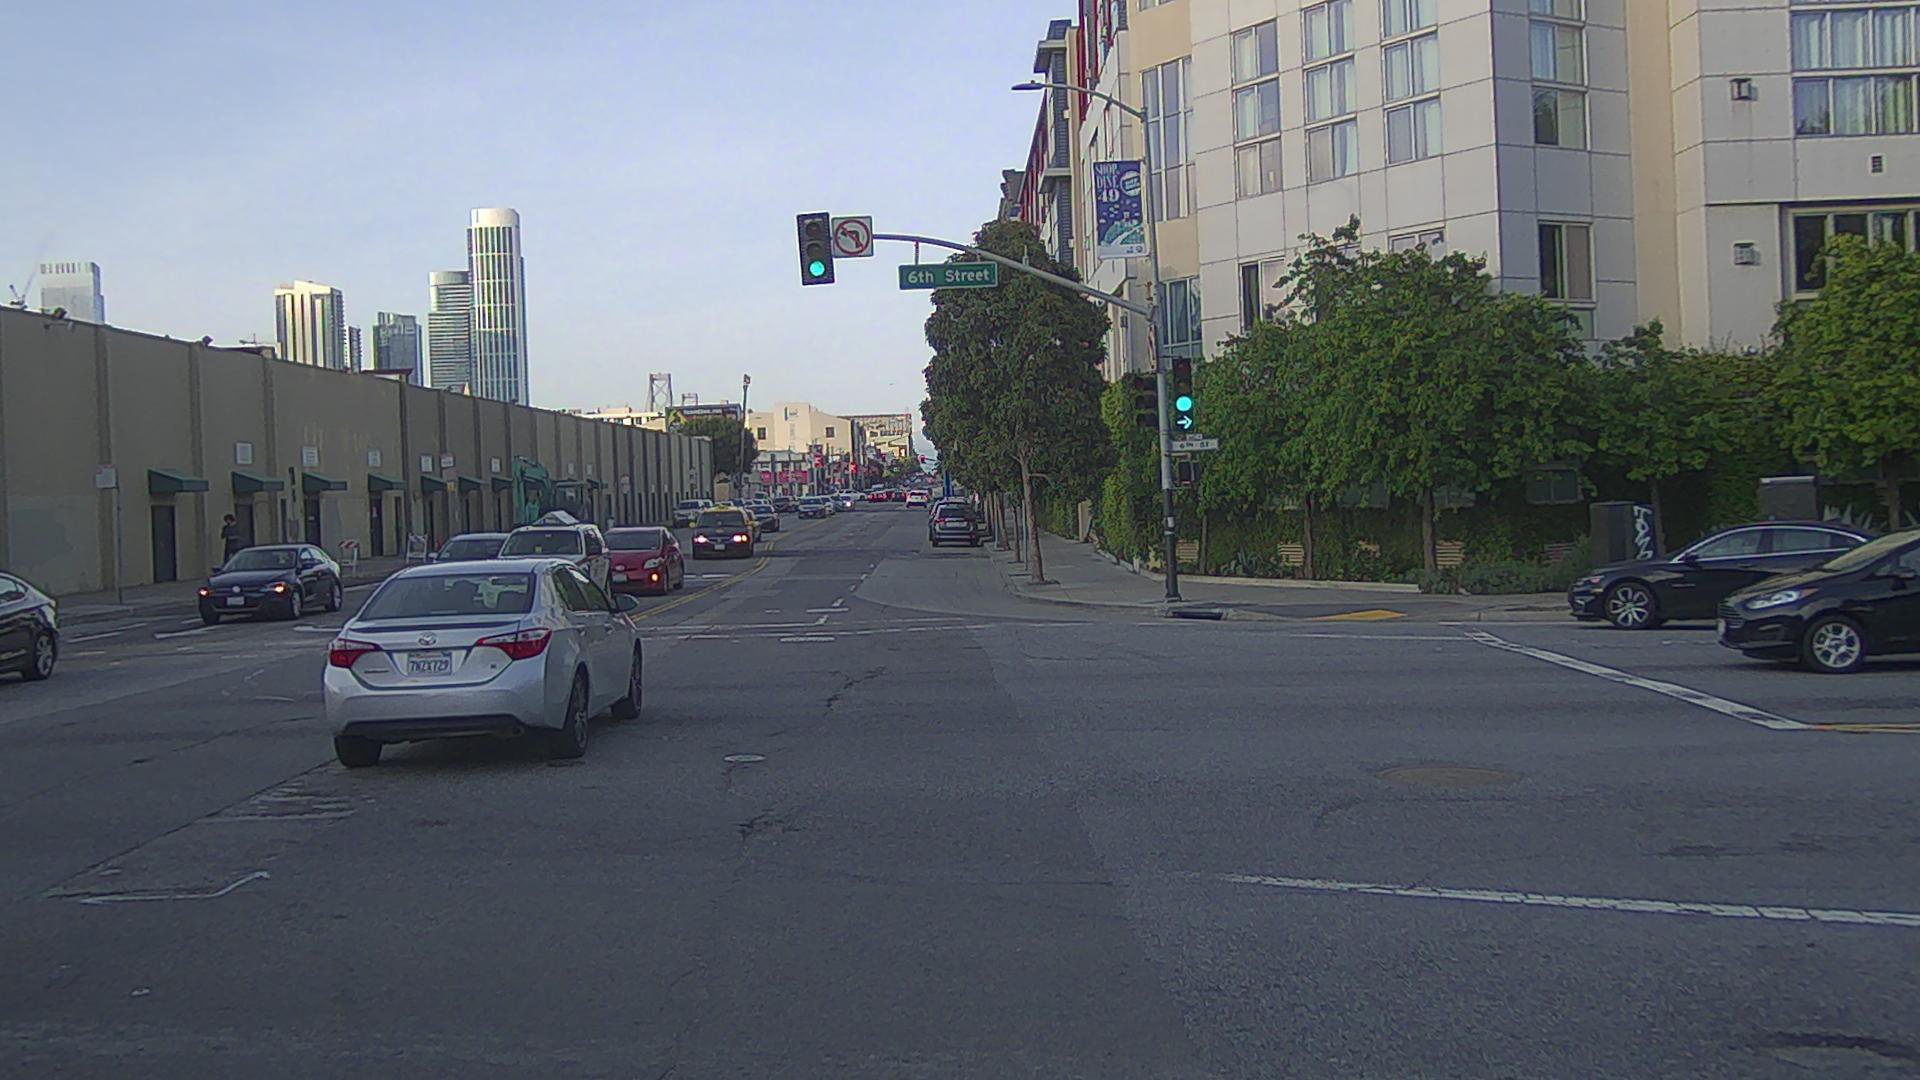

In [2]:
img_dir_num = 1
camera_type = "front_camera"
show_idx = [0, 1]

img_t0_path = glob(f"../data/{img_dir_num:03d}/camera/{camera_type}/*.jpg")[show_idx[0]]
img_t1_path = glob(f"../data/{img_dir_num:03d}/camera/{camera_type}/*.jpg")[show_idx[1]]


img_t0 = Image.open(img_t0_path)
img_t0

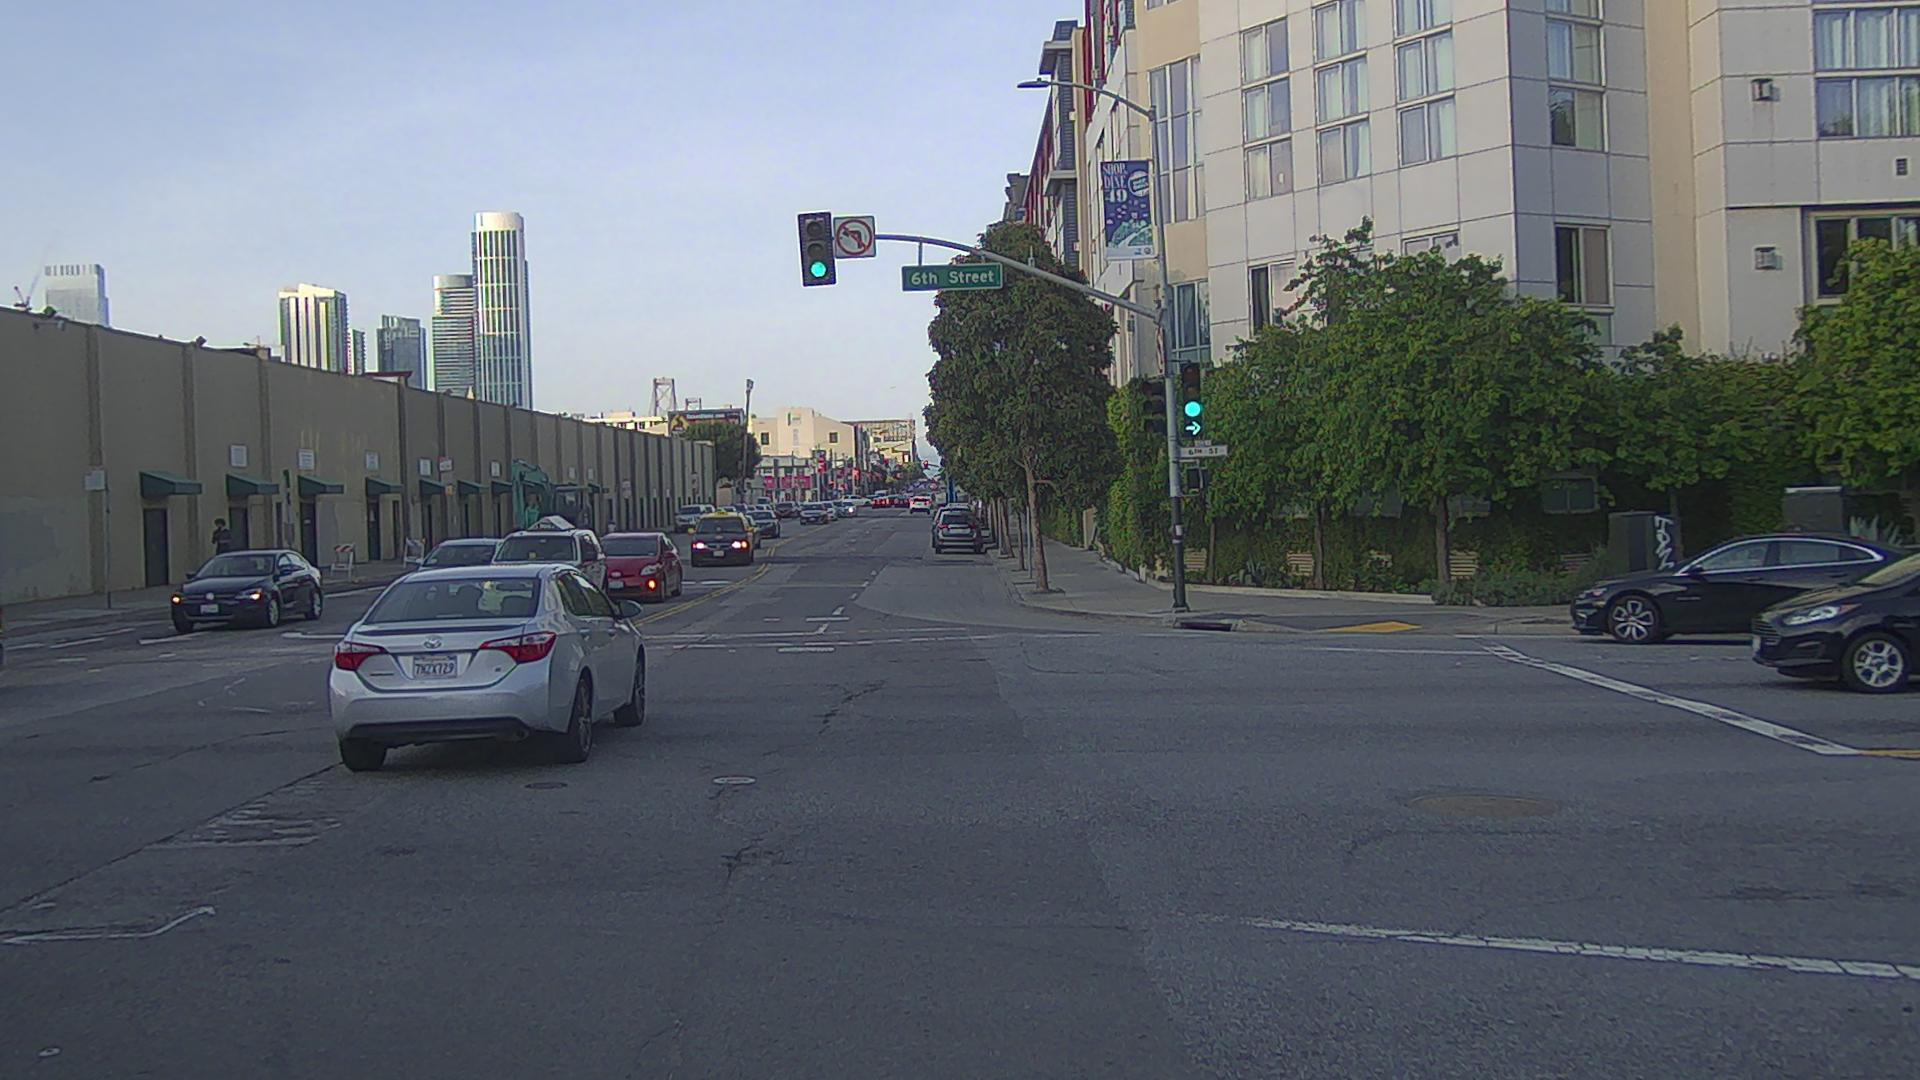

In [3]:
img_t1 = Image.open(img_t1_path)
img_t1

しかし、実際は自車両が移動しているため、画素レベルでは大きな違いが生じている。これを画素の差分で確認する

79057188


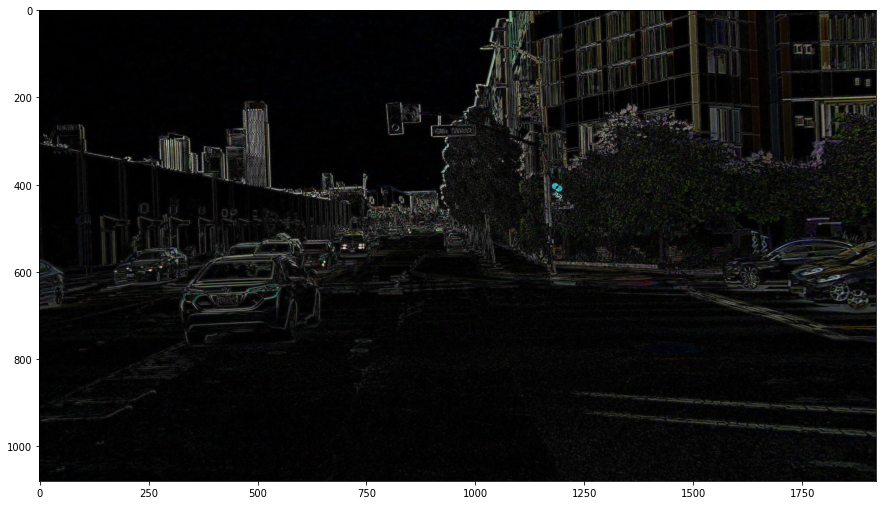

In [4]:
img_t0, img_t1 = np.array(img_t0).astype(np.int32), np.array(img_t1).astype(np.int32)
diff_t1_t0 = np.abs(img_t1 - img_t0)

plt.figure(figsize=(15, 15))
plt.imshow(diff_t1_t0)
print(np.sum(diff_t1_t0))

黒い箇所は画素の値の差が小さい場所だが、空と地面と壁は比較的に差分が少ないことがわかる。  
空は深度が大きく（つまり光線の反射元が遠い）自車両が多少進んでも変化がないためである。  
一方で、地面と壁はテクスチャの変化が少ないため、比較的に差分が小さい。  

上記の例で、移動により画像が変化したことを確かめた。
しかし、実は車両の姿勢・位置の変化および物体の表の3次元座標がわかっているならば、変化をキャンセルして画像を重ね合わせることが可能である。

ここでは、`intrinsics.json`、`poses.json`を使い、この重ね合わせを実行してみる。
この操作は深度推定の学習時に`Photometric loss`という誤差を計算するために使われるので重要である。  

この操作を理解するためにはカメラの投影モデルを理解している必要がある。
カメラの投影モデルは以下の式のように、カメラ座標（３次元）から画像平面（２次元）への投影として内部パラメタ・外部パラメタの行列をかけることで表される。  
![projection](http://opencv.jp/opencv-2.1/cpp/_images/math/a7fb9389364911f79ec6fb5067b4b49d60b9940c.png)  

画像平面（2D）からカメラ座標（3D）への投影はその逆だが、失われた次元の復元（３次復元と呼ぶ）するときに深度が必要になる。

今回は隣接する時刻t+0とt+1のフレームを利用する。t+1のフレームをt+0重ね合わせてみる。 重ね合わせには`cv2.remap()`を用いる。remapは一見してわかりにくい関数だが、これから説明する使用方法をみれば直感的に理解できるようになるはずである。

t+0とt+1の`pose.json`を読み込み、外部パラメタを計算する。ちなみに、内部パラメタはフレーム間では変化しない点に注意されたい。



## 外部パラメータを計算する

In [5]:
camera_pose_path = f"../data/{img_dir_num:03d}/camera/{camera_type}/poses.json"
with open(camera_pose_path, "r") as f:
    camera_poses = json.load(f)

In [6]:
camera_pose_t0 = camera_poses[show_idx[0]]
camera_pose_t1 = camera_poses[show_idx[1]]

In [7]:
print(camera_pose_t0)
print(camera_pose_t1)

{'position': {'x': 0.4089946812412687, 'y': 0.2613134190711932, 'z': 1.8091555545899585}, 'heading': {'w': 0.6578225673496162, 'x': -0.6474123760158749, 'y': 0.28335991415664824, 'z': -0.2604493123741657}}
{'position': {'x': 0.949616007909577, 'y': 0.8101681919803494, 'z': 1.8218365767094171}, 'heading': {'w': 0.6584078044422097, 'x': -0.6473552920891482, 'y': 0.28054678334854116, 'z': -0.262152229070342}}


In [8]:
# クォータニオン
camera_quat_t0 = np.array([camera_pose_t0["heading"]["w"],
                   camera_pose_t0["heading"]["x"],
                   camera_pose_t0["heading"]["y"],
                   camera_pose_t0["heading"]["z"]])

camera_quat_t1 = np.array([camera_pose_t1["heading"]["w"],
                   camera_pose_t1["heading"]["x"],
                   camera_pose_t1["heading"]["y"],
                   camera_pose_t1["heading"]["z"]])

In [9]:
# カメラ位置（ワールド座標）
camera_pos_t0 = np.array([camera_pose_t0["position"]["x"],
                   camera_pose_t0["position"]["y"],
                   camera_pose_t0["position"]["z"]])

camera_pos_t1 = np.array([camera_pose_t1["position"]["x"],
                   camera_pose_t1["position"]["y"],
                   camera_pose_t1["position"]["z"]])

poseとクォータニオンから、transform_matrixを計算する

In [10]:
# Compose translations(移動), rotations, zooms, [shears] to affine
camera_pose_mat_t0 = t3d.affines.compose(np.array(camera_pos_t0),
                                       t3d.quaternions.quat2mat(camera_quat_t0), # Calculate rotation matrix corresponding to quaternion
                                       [1.0, 1.0, 1.0])

camera_pose_mat_t1 = t3d.affines.compose(np.array(camera_pos_t1),
                                       t3d.quaternions.quat2mat(camera_quat_t1),
                                       [1.0, 1.0, 1.0])

In [11]:
print(camera_pose_mat_t0.shape)
print(camera_pose_mat_t1.shape)

(4, 4)
(4, 4)


In [12]:
#外部パラメータ行列
trans_lidar_to_camera_t0 = np.linalg.inv(camera_pose_mat_t0)
trans_lidar_to_camera_t1 = np.linalg.inv(camera_pose_mat_t1)

In [13]:
trans_lidar_to_camera_t0

array([[ 7.03746629e-01, -7.09560301e-01, -3.55648761e-02,
        -3.80686069e-02],
       [-2.42425599e-02,  2.60467421e-02, -9.99366732e-01,
         1.81111859e+00],
       [ 7.10037309e-01,  7.04163153e-01,  1.12874886e-03,
        -4.76450846e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [14]:
trans_lidar_to_camera_t1

array([[ 0.70513942, -0.70843304, -0.03001712, -0.04097549],
       [-0.01802074,  0.02441467, -0.99953948,  1.81833039],
       [ 0.70883965,  0.70535562,  0.00444926, -1.25268799],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

以上の操作により、外部パラメータ行列を算出した。

次に、内部パラメータ行列の読み込みを行う。

In [15]:
intrinsics_path = f"../data/{img_dir_num:03d}/camera/{camera_type}/intrinsics.json"
with open(intrinsics_path, "r") as f:
    intrinsics = json.load(f)

In [16]:
intrinsics

{'fx': 1970.0131, 'fy': 1970.0091, 'cx': 970.0002, 'cy': 483.2988}

In [17]:
intrinsic = np.array([
    [intrinsics["fx"], 0, intrinsics["cx"]],
    [0, intrinsics["fy"], intrinsics["cy"]],
    [0, 0, 1]
])

intrinsic

array([[1.9700131e+03, 0.0000000e+00, 9.7000020e+02],
       [0.0000000e+00, 1.9700091e+03, 4.8329880e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

# t+0の画像平面からワールド座標への投影
remap用のmapを作るために、t+0における画像座標をまずはワールド座標に投影する。  
画像座標からワールド座標への投影は先ほどのカメラの投影モデルの逆操作にあたるので、内部パラメータ行列と、外部パラメータ行列のそれぞれの逆行列を求めておく。

In [18]:
intrinsic_inv = np.linalg.inv(intrinsic)
trans_lidar_to_camera_t0_inv = np.linalg.inv(trans_lidar_to_camera_t0)

In [19]:
print(intrinsic_inv)
print()
print(trans_lidar_to_camera_t0_inv)

[[ 5.07610838e-04  0.00000000e+00 -4.92382614e-01]
 [ 0.00000000e+00  5.07611868e-04 -2.45328207e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

[[ 7.03746629e-01 -2.42425599e-02  7.10037309e-01  4.08994681e-01]
 [-7.09560301e-01  2.60467421e-02  7.04163153e-01  2.61313419e-01]
 [-3.55648761e-02 -9.99366732e-01  1.12874886e-03  1.80915555e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


3次元復元用に、depthを計算する。  
まず、lidarのデータを読み込む

In [20]:
lidar_path = f"../data/{img_dir_num:03d}/lidar/{show_idx[0]:02d}.pkl.gz"

with gzip.open(lidar_path, "r") as f:
    lidar = pickle.load(f)

In [21]:
lidar.head()

x          y         z     i             t  d
index                                                       
0     -58.457199 -61.269268  2.881014  39.0  1.557540e+09  0
1     -71.572182 -74.840317  1.279183   9.0  1.557540e+09  0
2     -42.442833 -44.357426  0.426503  56.0  1.557540e+09  0
3     -31.749357 -33.156342 -0.025245   3.0  1.557540e+09  0
4      -9.920758 -10.442794  1.010120   0.0  1.557540e+09  0

In [22]:
points3d_lidar_xyz = lidar[["x", "y", "z"]].to_numpy()
print(points3d_lidar_xyz)
print(points3d_lidar_xyz.shape)

[[-58.4571991  -61.26926804   2.88101435]
 [-71.5721817  -74.84031677   1.27918303]
 [-42.44283295 -44.35742569   0.42650267]
 ...
 [ 41.09126505  11.59871921   5.40852274]
 [ 34.50563012  24.58449691   5.67867862]
 [ 41.03754546  11.6692476    5.39646771]]
(169171, 3)


In [73]:
camera_points_3d = trans_lidar_to_camera_t0[:3, :3] @ (points3d_lidar_xyz.T) + trans_lidar_to_camera_t0[:3, 3].reshape(3, 1)

In [74]:
camera_points_3d.shape

(3, 169171)

In [75]:
distances = np.sqrt(np.square(camera_points_3d))

In [76]:
distances.shape

(3, 169171)

In [77]:
distances = np.sqrt(np.sum(np.square(camera_points_3d), axis=-1))

In [79]:
points2d_camera = intrinsic @ camera_points_3d # カメラ座標 -> 画像座標
points2d_camera = (points2d_camera[:2, :] / points2d_camera[2, :]).T # 同次座標?

In [80]:
points2d_camera.shape

(169171, 2)

In [81]:
condition = camera_points_3d[2, :] > 0.0
camera_points_3d = camera_points_3d[:, condition]

In [82]:
image_h, image_w, _ = img_t0.shape
condition = np.logical_and(
    (points2d_camera[:, 1] < image_h) & (points2d_camera[:, 1] > 0),
    (points2d_camera[:, 0] < image_w) & (points2d_camera[:, 0] > 0))
points2d_camera = points2d_camera[condition]
camera_points_3d = camera_points_3d.T[condition]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 114029 but corresponding boolean dimension is 169171

In [83]:
points2d_camera.shape

(82925, 2)

In [84]:
camera_points_3d.shape

(3, 114029)

In [85]:
distances.shape

(3,)

In [55]:
colors = cm.jet(distances / np.max(distances))
colors

array([[1.        , 0.9157589 , 0.        , 1.        ],
       [0.        , 0.        , 0.82085561, 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

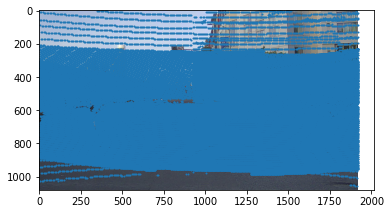

In [87]:
import matplotlib.cm as cm

plt.imshow(img_t0)
#colors = cm.jet(distances / np.max(distances))
plt.gca().scatter(points2d_camera[:, 0], points2d_camera[:, 1], s=1)